## learning-AI : deep learning application (61357002)
### assignment : linear AE vs non-linear AE

**DSADS 데이터셋을 이용하여 linear AE와 non-linear AE를 비교**

<br>

- **임규연 (lky473736)**
- 2024.10.17.에 문서 작성
    
## <span id='dl'><mark>DL</mark></span>
    
**DSA 데이터에서 lyingRigh과 lyingBack의 정상 데이터(각각 480개)를 사용하고, standingInElevatorStill 활동을 비정상 데이터로 설정**한다. 두 가지 활동(lying과 standingInElevatorStill)을 섞어서 데이터를 구성한 후, **lying 데이터만 사용하여 오토인코더를 학습**한다. 이후, 혼합된 테스트 데이터(lying+standingInElevatorStill)를 AE에 입력하여 **reconstruction error**(입력과 출력의 차이)를 계산한다. 적절한 임계값(threshold)을 설정하여 분류를 수행한 뒤, 모델의 정확도(accuracy)를 평가한다.

이때, linear AE와 non-linear AE를 각각 학습한 후에 두 metrics를 비교하겠다.

In [485]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [486]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


---

### 1. 탐색적 데이터 분석 및 데이터 전처리 수행
- 데이터 시각화 및 필요한 정보를 얻어낸다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.

In [487]:
# 데이터 로드

df = pd.read_csv('../../data/DSA_features.csv')
# df = pd.read_csv('../dataset/ae_data.csv')

df.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [488]:
# 데이터의 정보 및 기초통계량 확인

df.info() 
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


,count,mean,std,min,25%,50%,75%,max
T_xacc_mean,9120.0,7.765766,3.758022,-1.157566e+01,8.374161,9.186328,9.515573,10.713139
T_xacc_max,9120.0,14.625536,11.823448,-4.758700e+00,9.523200,12.549500,15.843250,93.694000
T_xacc_min,9120.0,3.602974,5.622855,-9.971500e+01,0.000000,5.757900,7.649075,9.749000
T_xacc_var,9120.0,17.807013,45.188787,1.353291e-04,0.036855,2.241468,6.680571,392.898630
T_xacc_std,9120.0,2.454290,3.432895,1.163310e-02,0.191977,1.497153,2.584680,19.821671
...,...,...,...,...,...,...,...,...
LL_zmag_max,9120.0,0.169687,0.360190,-9.108300e-01,-0.035821,0.210825,0.422270,1.042600
LL_zmag_min,9120.0,-0.052866,0.359712,-1.126000e+00,-0.326125,-0.040447,0.206933,0.999440
LL_zmag_var,9120.0,0.007625,0.019034,2.960874e-07,0.000223,0.001814,0.006928,0.279020
LL_zmag_std,9120.0,0.059342,0.064059,5.441392e-04,0.014925,0.042586,0.083234,0.528223


In [489]:
# 결측치 확인

'''
    결측치 없음을 확인 가능
'''

print (df.isnull().sum()) 
print (any(df.isnull().sum())) # False로 나왔으니 결측치가 없는 것임

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64
False


In [490]:
# class 종류 확인

print (f"class 종류 :  {np.unique(df['activity'])}")

class 종류 :  ['ascendingStairs' 'basketBall' 'crossTrainer' 'cyclingHorizontal'
 'cyclingVertical' 'decendingStairs' 'jumping' 'lyingBack' 'lyingRigh'
 'movingInElevator' 'rowing' 'runningTreadmill' 'sitting' 'standing'
 'standingInElevatorStill' 'stepper' 'walkingLot' 'walkingTreadmillFlat'
 'walkingTreadmillIncline']


In [491]:
# 3가지 행동추출 (lyingRigh, lyingBack, standingInElevatorStill)

df = df.loc[df['activity'].isin(['lyingRigh', 'lyingBack', 'standingInElevatorStill'])]
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.417440,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,p1
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.403720,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,p1
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.426160,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,p1
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.308770,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,p1
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.389000,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9.802530,9.8423,9.6857,0.000865,0.029403,-1.341638,-0.185503,-0.090833,-0.25891,0.001316,...,0.006399,-0.962316,0.488304,0.51448,0.46222,5.126574e-05,0.007160,-0.717994,standingInElevatorStill,p8
3356,9.799047,9.9038,9.7250,0.000750,0.027379,0.468885,-0.200147,-0.113400,-0.29976,0.001781,...,0.006276,-0.513505,0.488314,0.51509,0.46554,4.488257e-05,0.006699,0.136985,standingInElevatorStill,p8
3357,9.797938,9.8537,9.7347,0.000576,0.023998,-0.365021,-0.195523,-0.132300,-0.25615,0.001006,...,0.005879,0.691562,0.486659,0.51104,0.46926,4.251657e-05,0.006520,0.178792,standingInElevatorStill,p8
3358,9.606040,9.9302,9.1379,0.067806,0.260396,-0.719145,-0.188162,-0.119480,-0.25154,0.000760,...,0.007984,-0.736630,0.490615,0.53319,0.46602,8.602620e-05,0.009275,1.175198,standingInElevatorStill,p8


activity
lyingBack                  480
lyingRigh                  480
standingInElevatorStill    480
Name: count, dtype: int64


<Axes: xlabel='activity', ylabel='count'>

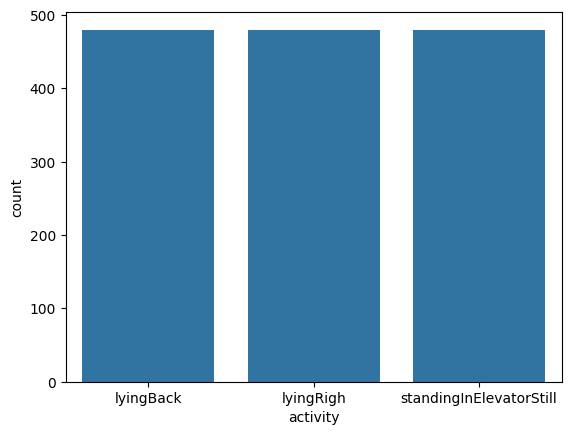

In [492]:
# target countplot

print (df['activity'].value_counts())
sns.countplot(x='activity', data=df)

In [493]:
# df에서 people 열 제거

df = df.drop('people', axis=1)

In [494]:
# what 열을 수정
# standing abnormal, lyingRigh이나 lyingBack은 normal

df['what'] = df['activity'].map({
    'standingInElevatorStill': 'abnormal',
    'lyingRigh': 'normal',
    'lyingBack': 'normal'
})

df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,what
960,-4.834646,-4.7185,-4.9049,0.001124,0.033529,0.632141,-0.501018,-0.417440,-0.59561,0.001016,...,0.000986,0.074676,-0.532664,-0.52993,-0.53521,9.585668e-07,0.000979,-0.193301,lyingBack,normal
961,-4.780810,-4.5850,-4.8833,0.003948,0.062835,1.052880,-0.480601,-0.403720,-0.63184,0.001297,...,0.000788,-0.181526,-0.531169,-0.52940,-0.53365,7.608973e-07,0.000872,-0.372381,lyingBack,normal
962,-4.804400,-4.7037,-4.8755,0.001482,0.038496,0.735226,-0.493925,-0.426160,-0.59561,0.000863,...,0.000677,-0.263115,-0.530569,-0.52873,-0.53222,5.160537e-07,0.000718,0.185587,lyingBack,normal
963,-4.750563,-4.5696,-4.8977,0.004447,0.066683,0.710263,-0.437358,-0.308770,-0.55225,0.003587,...,0.000686,-0.060925,-0.531167,-0.52962,-0.53283,4.975523e-07,0.000705,-0.145321,lyingBack,normal
964,-4.774916,-4.6741,-4.8457,0.001080,0.032868,0.324779,-0.459456,-0.389000,-0.53714,0.001059,...,0.000739,0.335811,-0.529804,-0.52706,-0.53251,1.292131e-06,0.001137,-0.026271,lyingBack,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,9.802530,9.8423,9.6857,0.000865,0.029403,-1.341638,-0.185503,-0.090833,-0.25891,0.001316,...,0.006399,-0.962316,0.488304,0.51448,0.46222,5.126574e-05,0.007160,-0.717994,standingInElevatorStill,abnormal
3356,9.799047,9.9038,9.7250,0.000750,0.027379,0.468885,-0.200147,-0.113400,-0.29976,0.001781,...,0.006276,-0.513505,0.488314,0.51509,0.46554,4.488257e-05,0.006699,0.136985,standingInElevatorStill,abnormal
3357,9.797938,9.8537,9.7347,0.000576,0.023998,-0.365021,-0.195523,-0.132300,-0.25615,0.001006,...,0.005879,0.691562,0.486659,0.51104,0.46926,4.251657e-05,0.006520,0.178792,standingInElevatorStill,abnormal
3358,9.606040,9.9302,9.1379,0.067806,0.260396,-0.719145,-0.188162,-0.119480,-0.25154,0.000760,...,0.007984,-0.736630,0.490615,0.53319,0.46602,8.602620e-05,0.009275,1.175198,standingInElevatorStill,abnormal


In [495]:
# df에서 activity 열 제거

df = df.drop('activity', axis=1)

In [496]:
# normal과 abnormal dataset을 구성, train set, test set 구성

abnormal = df[df.what == 'abnormal'] 
normal = df[df.what == 'normal']
 
train = normal.copy() # train data (normal만 학습시킴)
test = pd.concat([normal, abnormal])  # 합치기

train.shape, test.shape

((960, 271), (1440, 271))

<Axes: xlabel='what', ylabel='count'>

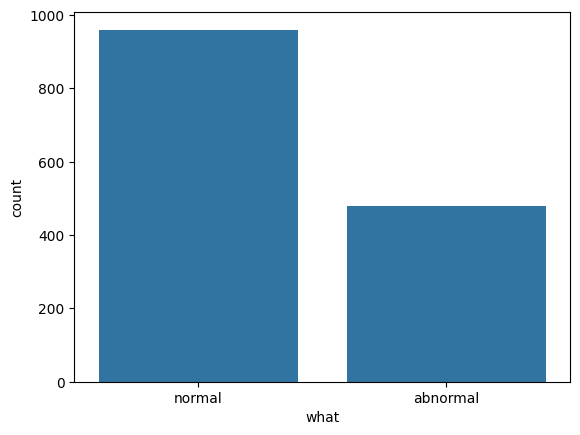

In [497]:
# normal과 abnormal 갯수 countplot

sns.countplot(x='what', data=df)

In [498]:
# normal을 0, abnormal을 1로 만들기

# train 데이터프레임에서 'what' 열 수정
train['what'] = 0 # 어차피 모든 열이 다 normal임

print (any(train['what'] == 1)) # false가 나오는게 정상임

# test 데이터프레임에서 'what' 열 수정
test['what'] = test['what'].map({
    'normal': 0,
    'abnormal': 1
})

print (train['what'].unique())
print (test['what'].unique())

False
[0]
[0 1]


In [499]:
# input, target split

y_train, X_train = train['what'], train.drop('what', axis=1)
y_test, X_test = test['what'], test.drop('what', axis=1)

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (y_train.unique(), y_test.unique())

(960, 270) (960,) (1440, 270) (1440,)
[0] [0 1]


In [500]:
# z-score normalization

from sklearn.preprocessing import StandardScaler

normalizier = StandardScaler()
X_train_scaled = normalizier.fit_transform(X_train)
X_test_scaled = normalizier.transform(X_test)

-----


### 2. linear AE 구성 후 anomaly detection 확인

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 64)             │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 270)            │         8,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,782 (116.34 KB)

 Trainable params: 29,782 (116.34 KB)

 Non-trainable params: 0 (0.00 B)

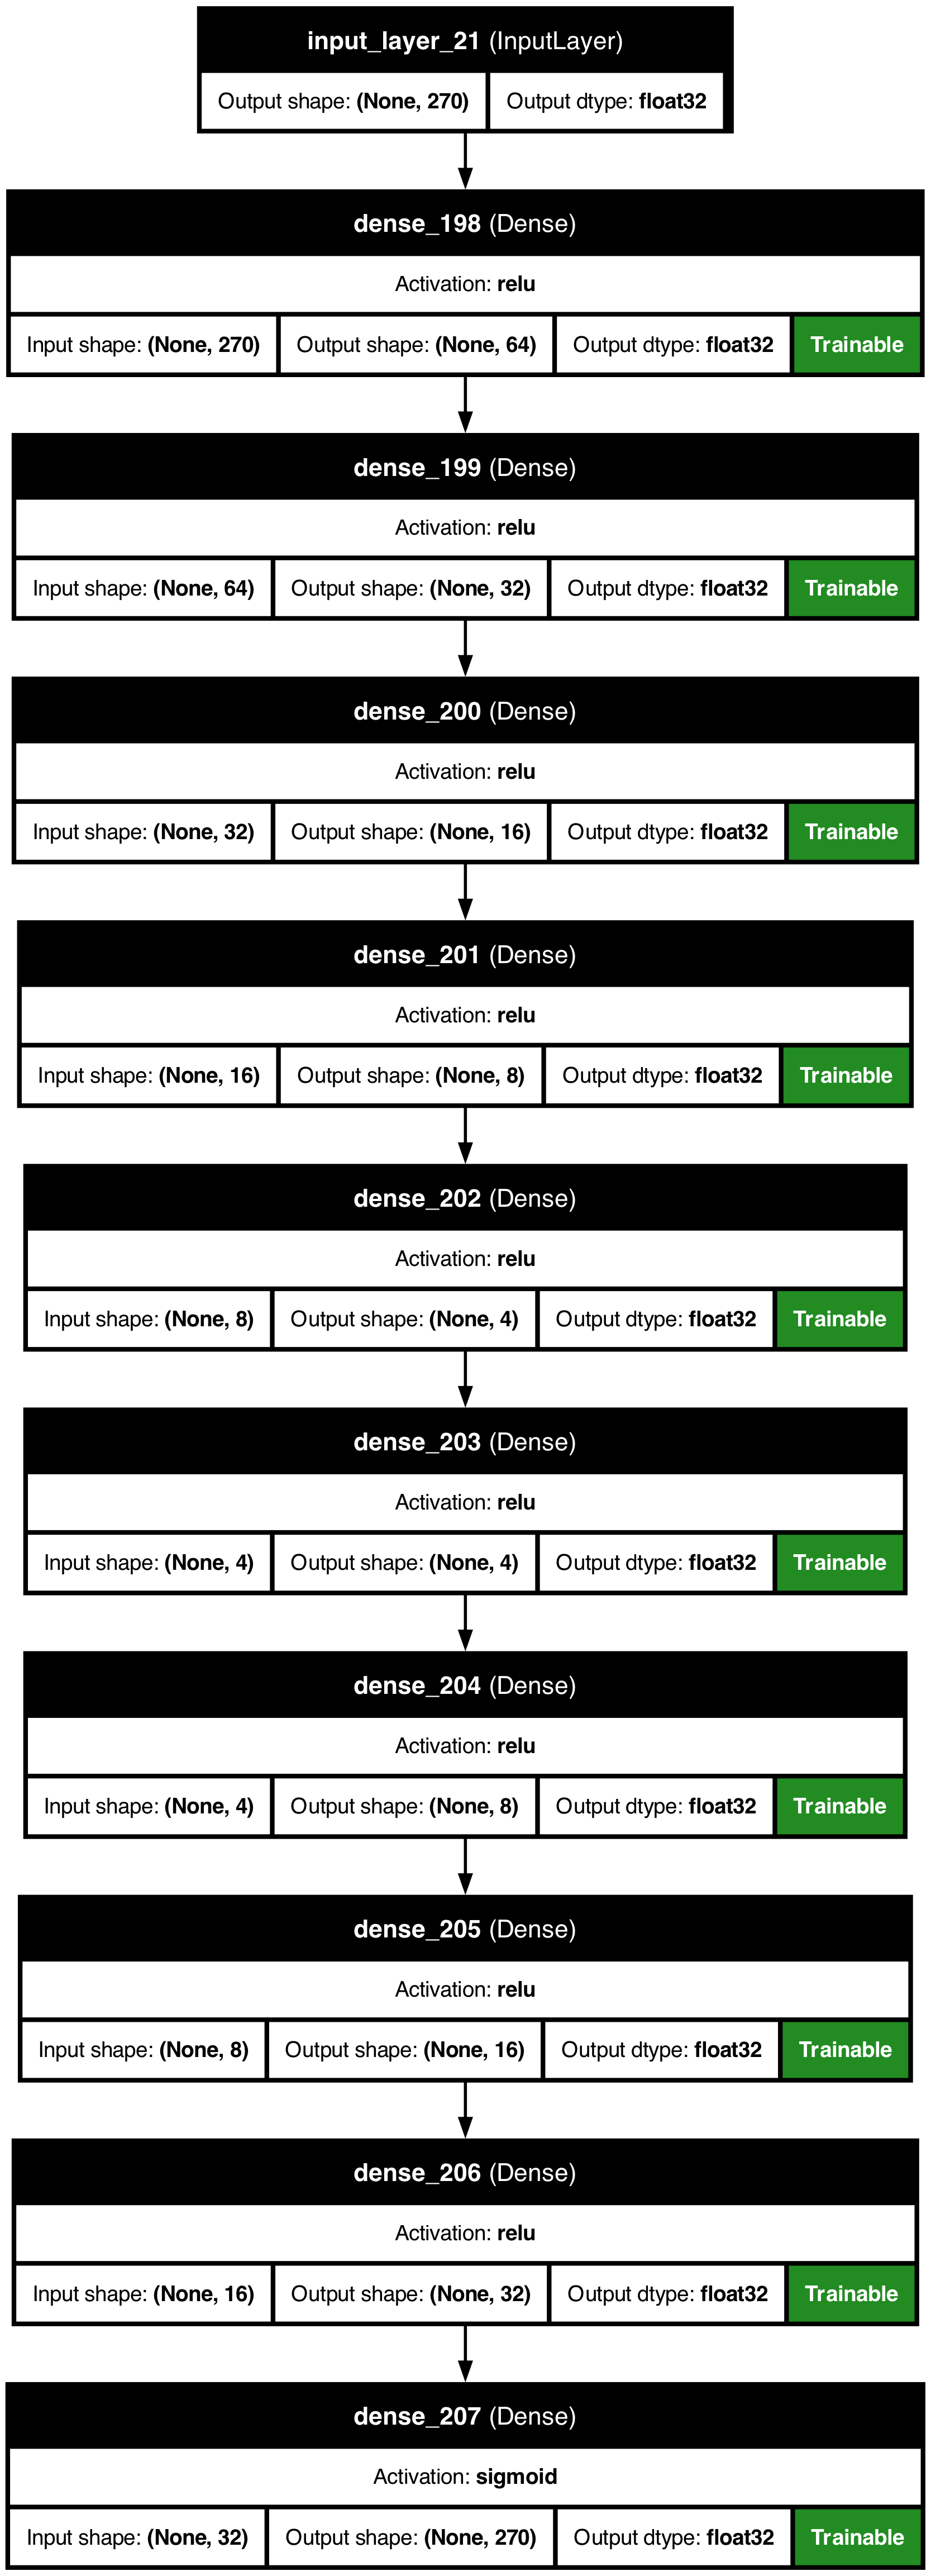

In [501]:
# modeling

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_dim = X_train.shape[1]  # feature의 갯수임
encoding_dim = 64

input_layer = Input(shape=(input_dim,))

# encoding 단계
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)
encoded = Dense(encoding_dim // 8, activation='relu')(encoded)
encoded = Dense(encoding_dim // 16, activation='relu')(encoded)

# decoding 단계
decoded = Dense(encoding_dim // 16, activation='relu')(encoded)
decoded = Dense(encoding_dim // 8, activation='relu')(decoded)
decoded = Dense(encoding_dim // 4, activation='relu')(decoded)
decoded = Dense(encoding_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, show_dtype=True,
                         show_layer_activations=True,
                         show_layer_names=True,
                         show_shapes=True,
                         show_trainable=True)

In [502]:
# compile

from keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [503]:
# fit

history = autoencoder.fit(X_train_scaled, X_train_scaled,  # 자기 자신을 training (비지도 학습)
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                         # callbacks=[early_stopping_cb],
                          validation_split = 0.1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.1710 - val_loss: 0.8402
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2334 - val_loss: 0.8401
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3818 - val_loss: 0.8399
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.3108 - val_loss: 0.8398
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2031 - val_loss: 0.8397
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4159 - val_loss: 0.8396
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2610 - val_loss: 0.8394
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2581 - val_loss: 0.8393
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2724 - val_loss: 0.8391
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1250 - val_loss: 0.8390
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3094 - val_loss: 0.8388
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4111 - val_loss: 0.8386
E

{'loss': [1.2955015897750854, 1.295356035232544, 1.2952115535736084, 1.2950602769851685, 1.2949022054672241, 1.2947320938110352, 1.2945456504821777, 1.2943512201309204, 1.2941420078277588, 1.29390287399292, 1.2936497926712036, 1.2933677434921265, 1.2930513620376587, 1.2927011251449585, 1.292305588722229, 1.291857361793518, 1.291351079940796, 1.2907744646072388, 1.2901214361190796, 1.289366602897644, 1.2884942293167114, 1.2875030040740967, 1.2863738536834717, 1.2850754261016846, 1.2835779190063477, 1.281888723373413, 1.2799700498580933, 1.2777892351150513, 1.275304913520813, 1.2725393772125244, 1.2694287300109863, 1.2659215927124023, 1.2621124982833862, 1.2578237056732178, 1.2531331777572632, 1.248040795326233, 1.2424736022949219, 1.23652184009552, 1.2300764322280884, 1.223249077796936, 1.216062068939209, 1.2085176706314087, 1.2006230354309082, 1.1925311088562012, 1.1842621564865112, 1.1758753061294556, 1.1673556566238403, 1.1588722467422485, 1.150451421737671, 1.1422258615493774], 'val

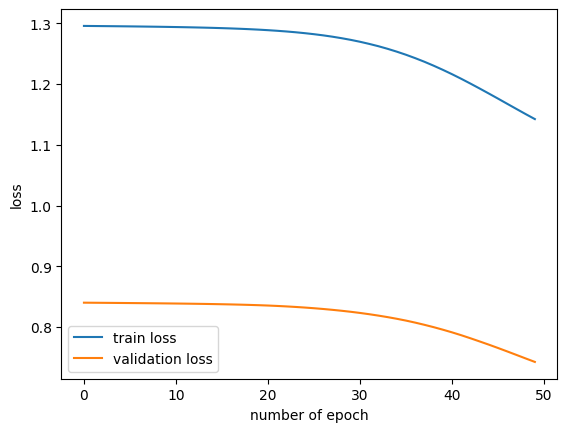

'\n    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.\n'

In [504]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

'''
    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.
'''

In [505]:
# reconstruction error 

predictions = autoencoder.predict(X_test_scaled) 
reconstruction_error = np.mean(np.square(X_test_scaled - predictions), axis=1) # mse

error_df_linear = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'true_class': y_test
})

'''
    reconstruction error가 높다 -> fraud일 가능성이 매우 높아지는 것 
    (실제 정상인 데이터를 가지고 모델을 학습시켰으니 이상한 값에 대하여 loss가 많을 것)
'''

error_summary = error_df_linear.describe()
error_summary

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,reconstruction_error,true_class
count,1440.000000,1440.000000
mean,131.452281,0.333333
std,544.933267,0.471568
min,0.322470,0.000000
25%,0.566574,0.000000
50%,0.743383,0.000000
75%,4.003713,1.000000
max,6219.923638,1.000000


In [506]:
error_df_linear

,reconstruction_error,true_class
960,0.378789,0
961,0.415373,0
962,0.385285,0
963,0.428602,0
964,0.410262,0
...,...,...
3355,2.382324,1
3356,2.176537,1
3357,2.171696,1
3358,3.258268,1


In [507]:
# 임계값 설정

mean_error = error_df_linear['reconstruction_error'].mean()
std_error = error_df_linear['reconstruction_error'].std()

k = 2
threshold = 1
# (mean_error + k * std_error) 

print (threshold)

1


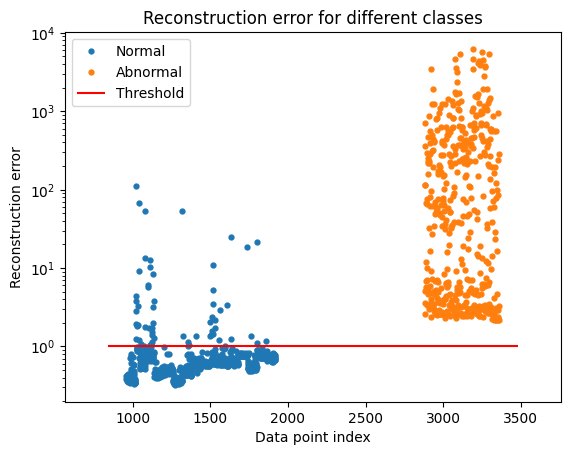

In [508]:
# reconstruction error visualization

import math

groups = error_df_linear.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups :
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
ax.set_yscale('log')
ax.hlines(math.log(threshold), ax.get_xlim()[0], ax.get_xlim()[1], colors="b", zorder=100, label='Threshold')

plt.show();

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       960
           1       0.89      1.00      0.94       480

    accuracy                           0.96      1440
   macro avg       0.94      0.97      0.95      1440
weighted avg       0.96      0.96      0.96      1440



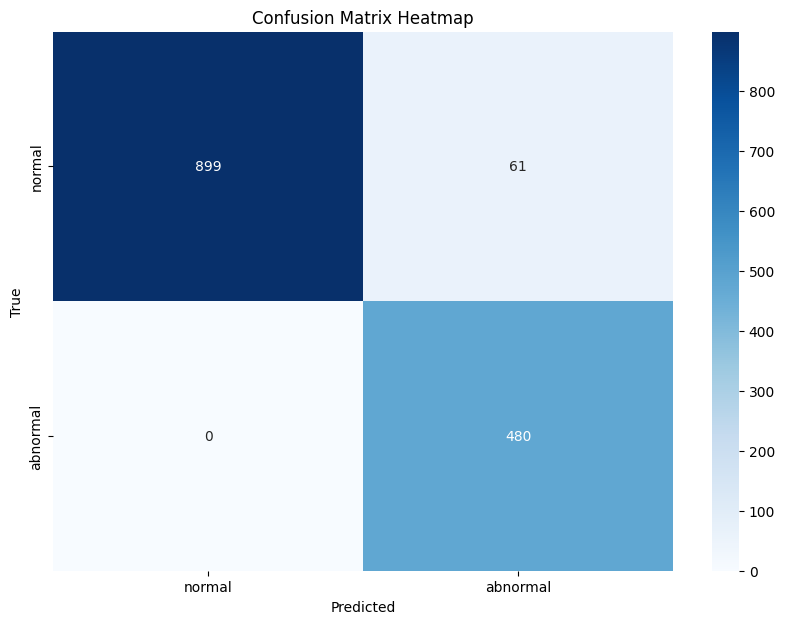

In [509]:
# classification report, heatmap

from sklearn.metrics import confusion_matrix, classification_report

error_df_linear['predicted_class'] = (error_df_linear['reconstruction_error'] > threshold).astype(int)
print(classification_report(error_df_linear['true_class'], error_df_linear['predicted_class']))

cm_linear = confusion_matrix(error_df_linear['true_class'], error_df_linear['predicted_class'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'abnormal'], 
            yticklabels=['normal', 'abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

-----


### 3. non-linear AE 구성 후 anomaly detection 확인

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 64)             │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 6)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 21)             │           357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 270)            │         5,940 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,608 (103.94 KB)

 Trainable params: 26,608 (103.94 KB)

 Non-trainable params: 0 (0.00 B)

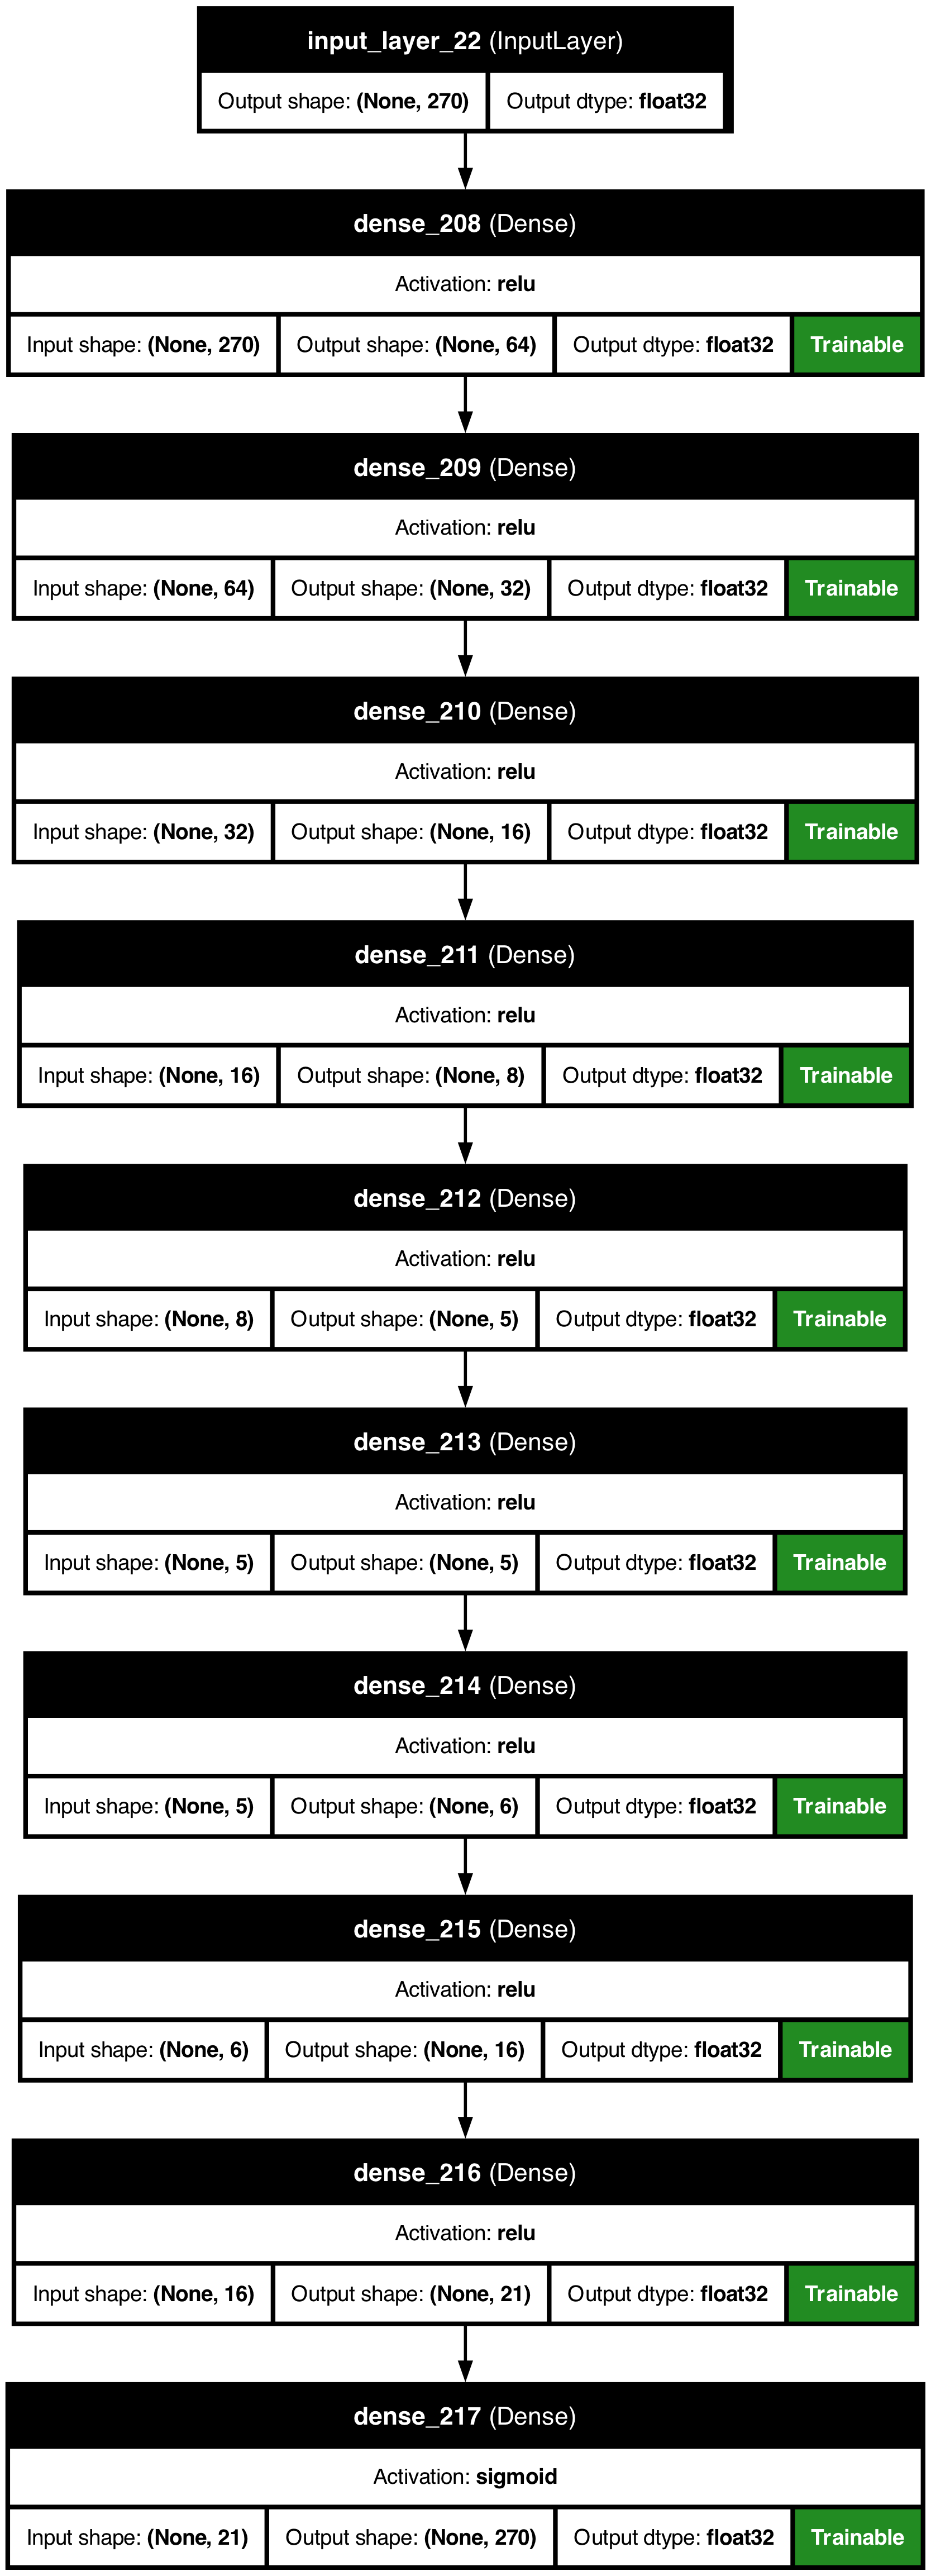

In [510]:
# modeling

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_dim = X_train.shape[1]  # feature의 갯수임
encoding_dim = 64

input_layer = Input(shape=(input_dim,))

# encoding 단계
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(encoding_dim // 2, activation='relu')(encoded)
encoded = Dense(encoding_dim // 4, activation='relu')(encoded)
encoded = Dense(encoding_dim // 8, activation='relu')(encoded)
encoded = Dense(encoding_dim // 12, activation='relu')(encoded)

# decoding 단계
decoded = Dense(encoding_dim // 12, activation='relu')(encoded)
decoded = Dense(encoding_dim // 10, activation='relu')(decoded)
decoded = Dense(encoding_dim // 4, activation='relu')(decoded)
decoded = Dense(encoding_dim // 3, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, show_dtype=True,
                         show_layer_activations=True,
                         show_layer_names=True,
                         show_shapes=True,
                         show_trainable=True)

In [511]:
# compile

from keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [512]:
# fit

history = autoencoder.fit(X_train_scaled, X_train_scaled,  # 자기 자신을 training (비지도 학습)
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                         # callbacks=[early_stopping_cb],
                          validation_split = 0.1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 1.2385 - val_loss: 0.8399
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3740 - val_loss: 0.8398
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4060 - val_loss: 0.8396
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2292 - val_loss: 0.8395
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2047 - val_loss: 0.8393
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1598 - val_loss: 0.8391
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4291 - val_loss: 0.8390
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2623 - val_loss: 0.8388
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2836 - val_loss: 0.8386
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4778 - val_loss: 0.8384
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2566 - val_loss: 0.8382
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2478 - val_loss: 0.8379
E

{'loss': [1.2954232692718506, 1.2952134609222412, 1.29499351978302, 1.2947794198989868, 1.2945584058761597, 1.294316053390503, 1.2940521240234375, 1.2937757968902588, 1.2934671640396118, 1.2931299209594727, 1.292757272720337, 1.2923425436019897, 1.2918661832809448, 1.2913365364074707, 1.2907339334487915, 1.2900596857070923, 1.289306402206421, 1.2884494066238403, 1.2875056266784668, 1.2864397764205933, 1.285263180732727, 1.2839468717575073, 1.2824879884719849, 1.2808700799942017, 1.279046893119812, 1.2771050930023193, 1.2748682498931885, 1.27247953414917, 1.2698280811309814, 1.2669365406036377, 1.263789415359497, 1.2603700160980225, 1.2566431760787964, 1.2526429891586304, 1.2483774423599243, 1.2437080144882202, 1.2387547492980957, 1.2334707975387573, 1.2278878688812256, 1.221990704536438, 1.2157247066497803, 1.2092453241348267, 1.2024469375610352, 1.195656657218933, 1.1886003017425537, 1.1814213991165161, 1.1742197275161743, 1.1670339107513428, 1.1598684787750244, 1.152795433998108], 'v

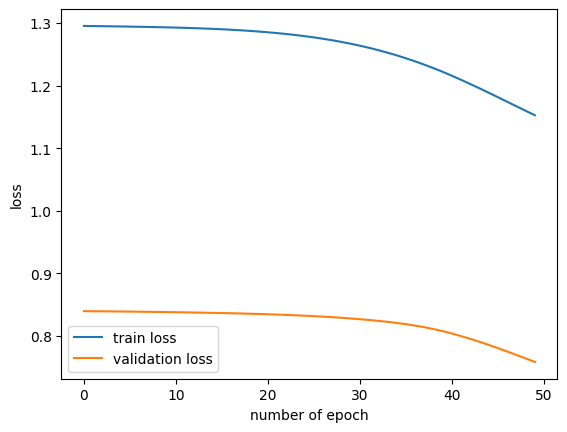

'\n    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.\n'

In [513]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

'''
    일반적으로 autoencoder는 분류를 다루지 않기 때문에 acc가 나오지 않는다.
'''

In [514]:
# reconstruction error 

predictions = autoencoder.predict(X_test_scaled) 
reconstruction_error = np.mean(np.square(X_test_scaled - predictions), axis=1) # mse

error_df_nonlinear = pd.DataFrame({
    'reconstruction_error': reconstruction_error,
    'true_class': y_test
})

'''
    reconstruction error가 높다 -> fraud일 가능성이 매우 높아지는 것 
    (실제 정상인 데이터를 가지고 모델을 학습시켰으니 이상한 값에 대하여 loss가 많을 것)
'''

error_summary = error_df_nonlinear.describe()
error_summary

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


,reconstruction_error,true_class
count,1440.000000,1440.000000
mean,131.727380,0.333333
std,545.494919,0.471568
min,0.350721,0.000000
25%,0.572010,0.000000
50%,0.730380,0.000000
75%,3.996635,1.000000
max,6221.790280,1.000000


In [515]:
error_df_nonlinear

,reconstruction_error,true_class
960,0.422163,0
961,0.451999,0
962,0.420528,0
963,0.473401,0
964,0.441649,0
...,...,...
3355,2.375625,1
3356,2.184325,1
3357,2.170123,1
3358,3.253930,1


In [516]:
# 임계값 설정

mean_error = error_df_nonlinear['reconstruction_error'].mean()
std_error = error_df_nonlinear['reconstruction_error'].std()

k = 2
threshold = 1
# (mean_error + k * std_error) - 1000

print (threshold)

1


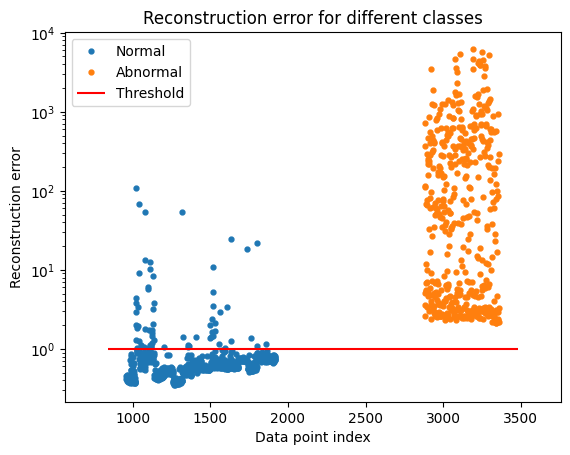

In [517]:
# reconstruction error visualization

import math

groups = error_df_nonlinear.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups :
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
ax.set_yscale('log')
ax.hlines(math.log(threshold), ax.get_xlim()[0], ax.get_xlim()[1], colors="b", zorder=100, label='Threshold')

plt.show();

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       960
           1       0.88      1.00      0.94       480

    accuracy                           0.95      1440
   macro avg       0.94      0.97      0.95      1440
weighted avg       0.96      0.95      0.96      1440



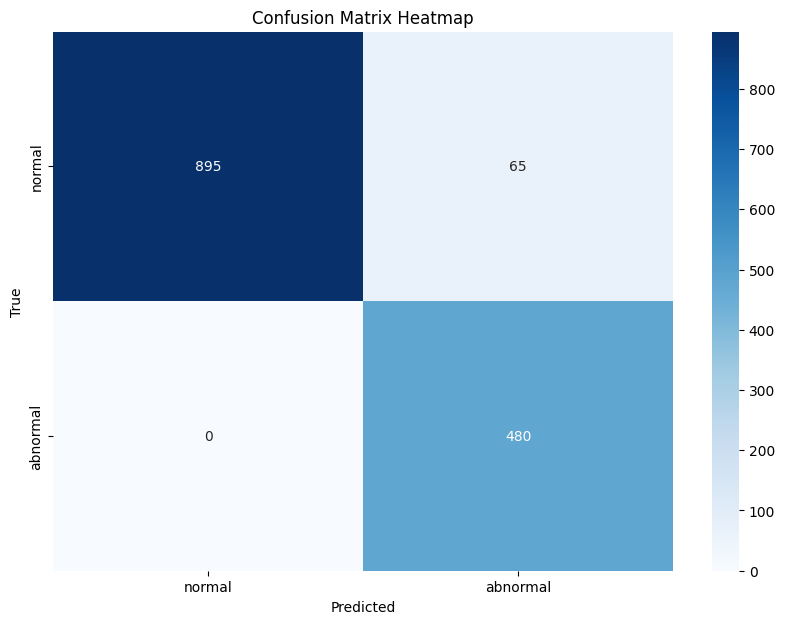

In [518]:
# classification report, heatmap

from sklearn.metrics import confusion_matrix, classification_report

error_df_nonlinear['predicted_class'] = (error_df_nonlinear['reconstruction_error'] > threshold).astype(int)
print(classification_report(error_df_nonlinear['true_class'], error_df_nonlinear['predicted_class']))

cm_nonlinear = confusion_matrix(error_df_nonlinear['true_class'], error_df_nonlinear['predicted_class'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_nonlinear, annot=True, fmt='d', cmap='Blues',
            xticklabels=['normal', 'abnormal'], 
            yticklabels=['normal', 'abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

------

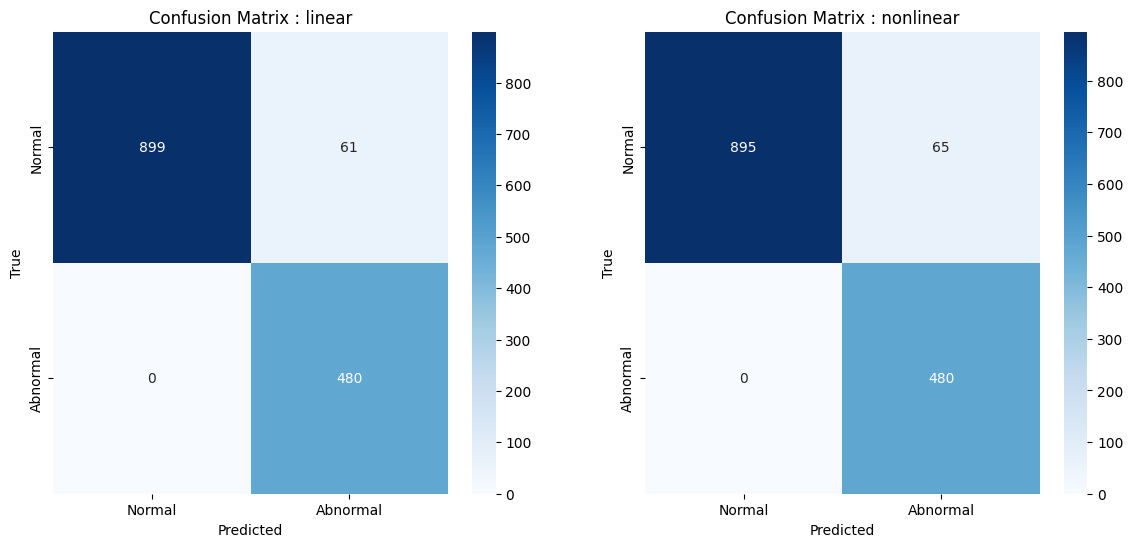

In [519]:
# heatmap comparison

cm1 = cm_linear
cm2 = cm_nonlinear 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
axes[0].set_title('Confusion Matrix : linear')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
axes[1].set_title('Confusion Matrix : nonlinear')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.show()